In [1]:
import os
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [2]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [3]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [4]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
import tensorflow as tf
gpus=tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
        )
    except RuntimeError as e:
        print(e)

In [6]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
LABEL_MAP_NAME = 'label_map.pbtxt'

In [17]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np

In [18]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)


In [19]:

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)


In [20]:
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
# ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')

In [21]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


In [22]:
import object_detection
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [23]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [24]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [25]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [26]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

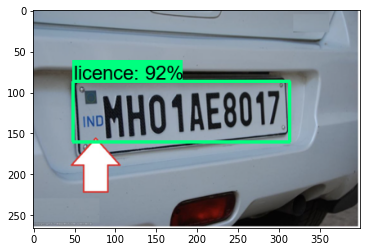

In [27]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'train', 'Cars210.png')
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [69]:
detections

{'detection_boxes': array([[0.3286391 , 0.12241524, 0.6015709 , 0.7851798 ],
        [0.33912066, 0.32609153, 0.54507303, 0.7757716 ],
        [0.38743877, 0.10848093, 0.68781376, 0.8164371 ],
        [0.23325452, 0.18350619, 0.75593317, 0.7189949 ],
        [0.7788352 , 0.957708  , 0.85111344, 0.9932833 ],
        [0.80546427, 0.9586938 , 0.87350595, 0.99316305],
        [0.36681375, 0.29383102, 0.61661136, 0.7697859 ],
        [0.80055225, 0.9486126 , 0.8733529 , 0.98438644],
        [0.77339154, 0.9468733 , 0.85021263, 0.98436487],
        [0.7500584 , 0.9538407 , 0.82666564, 0.99252063],
        [0.97634196, 0.577729  , 1.        , 0.8382361 ],
        [0.36080822, 0.14084935, 0.55347896, 0.6847475 ],
        [0.29523885, 0.18566768, 0.60264623, 0.5383389 ],
        [0.26448965, 0.46084535, 0.5956572 , 0.7641964 ],
        [0.7193943 , 0.9474338 , 0.8010249 , 0.9913341 ],
        [0.28909284, 0.34834087, 0.60004526, 0.6948812 ],
        [0.32387996, 0.5933547 , 0.41331887, 0.777431

In [70]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [29]:
import easyocr

In [30]:
detection_threshold=0.7

In [34]:
scores

[0.9231103]

In [33]:
image=image_np_with_detections
scores=list(filter(lambda x:x > detection_threshold,detections['detection_scores']))
boxes=detections['detection_boxes'][:len(scores)]
classes=detections['detection_classes'][:len(scores)]

In [43]:
boxes

array([[0.4724394 , 0.45906976, 0.6357397 , 0.8451834 ]], dtype=float32)

In [44]:
scores

[0.82224876]

In [45]:
classes

array([0], dtype=int64)

In [36]:
width=image.shape[1]
height=image.shape[0]

In [37]:
width


400

In [58]:
import torch
torch.cuda.empty_cache()

[0.3286391  0.12241524 0.6015709  0.7851798 ]
[ 87.41799796  48.96609783 160.01786053 314.07191753]
[([[0, 0], [266, 0], [266, 73], [0, 73]], 'FHHO IAE8O1Z] ^', 0.06979681023935662)]


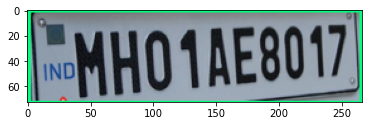

In [38]:
for idx,box in enumerate(boxes):
    print(box)
    roi=box*[height,width,height,width]
    print(roi)
    region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader=easyocr.Reader(['en'])
    ocr_result=reader.readtext(region)
    print(ocr_result)
    
    plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))

In [56]:
ocr_result[0][1]

'KLC1CA2555]'

In [46]:
region_threshold=0.6

In [42]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][1],result[0][1])))

0


In [44]:
def filter_text(region,ocr_result,region_threshold):
    rectangle_size=region.shape[0]*region.shape[1]
    
    plate=[]
    
    for result in ocr_result:
        length=np.sum(np.subtract(result[0][1],result[0][0]))
        height=np.sum(np.subtract(result[0][2],result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])

            
        print(length,width)
    return plate
    

In [47]:
filter_text(region,ocr_result,region_threshold)

266 400


['FHHO IAE8O1Z] ^']

In [55]:
def ocr_it(image,detections,detection_threshold,region_threshold):
    
    #scores ,boxes , threshold
    scores=list(filter(lambda x:x > detection_threshold,detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]
    
    #full image dim
    
    width=image.shape[1]
    height=image.shape[0]
    
    for idx,box in enumerate(boxes):
#         print(box)
        roi=box*[height,width,height,width]
#         print(roi)
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader=easyocr.Reader(['en'])
        ocr_result=reader.readtext(region)
#         print(ocr_result)
        
        text=filter_text(region,ocr_result,region_threshold)
    

        plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))
        
        print(text)
        
        return text,region
    
    

In [54]:
# plt.imshow(image_np_with_detections)
# detections
# detection_threshold
# region_threshold

0.6

In [59]:
text,region=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 184.28 MiB already allocated; 1.70 MiB free; 192.00 MiB reserved in total by PyTorch)

In [60]:
###LIVE DEMO

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break